In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
import matplotlib.font_manager
from enum import Enum
from abc import ABC
from datetime import datetime
import math
from collections import defaultdict

In [35]:
#to speed up testing
# MAX_NUM_ROWS=50000
MAX_NUM_ROWS=10000000000

MEDIASERVER_IDLE_TIMEOUT = 60

In [36]:
fontName = 'YS Text'
fontColor = '#FF6427'
fontColor2 = '#000000'

font_files = matplotlib.font_manager.findSystemFonts(fontpaths='/usr/share/fonts/truetype')
for font_file in font_files:
    try: 
        matplotlib.font_manager.fontManager.addfont(font_file)
    except Exception:
        print('failed to add font ' + font_file)
        #ignore
font = {'family' : 'YS Text',
        'size'   : 16}

matplotlib.rc('font', **font)

failed to add font /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf


In [37]:
calls  = pd.read_csv('calls_data_week.tsv', header=0, names=['msid','peer_id', 'room_id', 'rsid', 'ts_connected', 'ts_joined', 'ts_leave', 'ts_offer'], delimiter='\t', nrows=MAX_NUM_ROWS)
calls.head(15)

,msid,peer_id,room_id,rsid,ts_connected,ts_joined,ts_leave,ts_offer
0,0000007e-22c5-44e3-a5b4-6e724cab72f3,ff3983ed0d21ef95c84726261c13062c,476174964b7c4c87a4f1d70de2d768c1,f0f52923-8247-4e7c-a58e-e377c17b5df7,"2023-10-04 12:53:13,550","2023-10-04 12:53:10,991","2023-10-04 13:01:04,423","2023-10-04 12:53:12,446"
1,00001d39-3b30-4556-9c4a-1f3eded0e43c,843e13d0a9d4719f4e6c2f51d2afdde4,bbf146c4e05f4973840efac8086d39a2,b1e97bda-a33f-4b67-b209-2476093badf8,"2023-10-06 13:42:05,821","2023-10-06 13:42:03,634","2023-10-06 13:46:18,365","2023-10-06 13:42:04,982"
2,00003b2d-2518-4325-97e0-aab6467f00f4,5b01803546254b632d9df477d8392b6a,0b3f502c7a8e407aa37165c4e7e88973,efe80b25-1027-46d0-a5ad-e98fb30ecff0,"2023-10-06 10:32:28,067","2023-10-06 10:32:26,391","2023-10-06 10:32:49,821","2023-10-06 10:32:27,224"
3,00004e6f-fee4-471a-bbff-399351a12471,2c47e32aaf4efd1cf14271793c7ad12a,48bb4b75c1e9498986b12886692cd598,a3969583-2b64-4137-bb5d-2d315229f784,"2023-10-06 15:02:05,612","2023-10-06 15:02:04,488","2023-10-06 15:38:53,565","2023-10-06 15:02:05,122"
4,00005d4e-de60-41a0-bd94-deb0f6284f1b,75ba7bf99e68b847ade90cb3aabc3ed7,8dbea6698ce24776abd64e564578b549,ad3700b0-7783-4c46-84ec-d1c414676b99,"2023-10-02 10:30:36,448","2023-10-02 10:30:35,473","2023-10-02 10:39:11,117","2023-10-02 10:30:36,056"
5,00006053-8e1f-42c8-8cf4-6d9a72f67da9,de6640972520cabc51406d9e3fb81be9,ae3b4a8ffada450cb3f48f9b6adf5453,2aff682e-21a2-4069-8222-17c5b5572bae,"2023-10-05 08:58:13,460","2023-10-05 08:58:12,361","2023-10-05 09:22:24,344","2023-10-05 08:58:13,035"
6,00007318-89a1-45c7-aca1-1cec9421242a,e0d1523ddd805ad7ec4b195ef47cda59,2780b442f7b04af7b205c39bf36eebb1,29b7637f-9d55-4857-b9b1-cbec6e31d610,"2023-10-05 14:41:43,238","2023-10-05 14:41:42,213","2023-10-05 19:35:57,912","2023-10-05 14:41:42,750"
7,00008117-5363-4280-8a44-61b0787db874,1ca55eea38a06df36cd07b8a69ecd1dc,c6cc94beb83f44c2916daebebb729f90,53b962c8-4d5e-4db5-9198-1839f648e587,"2023-10-04 13:08:06,460","2023-10-04 13:08:01,095","2023-10-04 16:00:23,416","2023-10-04 13:08:03,718"
8,000086c1-63eb-4a96-b43d-92c5ab3aae13,344f5b361629fefd67708680e656f040,3370f30750c0412687f6e5bbca1578c2,70b7ae66-76ba-46a9-960c-d2f5885dc1c7,"2023-10-06 15:27:15,012","2023-10-06 15:27:01,524","2023-10-06 15:27:13,880","2023-10-06 15:27:02,997"
9,0000916d-bd12-489a-88f2-3364d1217bf2,c5b6247a50b3b48d7451ca4ae18ade3b,9c91308553be4342a7f39682770fed5b,816e132b-78d3-4a52-b65e-7bd6cf218a2e,"2023-10-08 10:59:55,894","2023-10-08 10:59:53,089","2023-10-08 11:00:08,544","2023-10-08 10:59:54,220"


In [38]:
#model parameters
NUM_NODES = 600
RECONNECT_DOWNTIME_SECONDS = 10

#parameters to optimize
GRACE_PERIOD_SECONDS = 1800
DISRUPTION_BUDGET = 60


class NewNodePolicy(Enum):
    #pick a new media server at random
    RANDOM = 0
    #pick servers sequentially when new conference is needed
    ROUND_ROBIN = 1
    #check out number of sessions on the nodes and pick the least loaded
    LEAST_LOADED = 2
    #pick an island at random and pick the least loaded node on it
    RANDOM_ISLAND_LEAST_LOADED = 3


class RMSConnection(ABC):
    room_id: str
    peer_id: str
    msid: str
    rsid: str
    ts_joined: datetime
    ts_connected: datetime
    ts_leave: datetime
    

class PeerConnection(ABC):
    room_id: str
    peer_id: str
    ts_joined: datetime
    ts_connected: datetime
    ts_leave: datetime
    rmsConnections: list[RMSConnection]

    def __init__(self, rmsConnections: list[RMSConnection]):
        self.room_id = rmsConnections[0].room_id
        self.peer_id = rmsConnections[0].peer_id
        self.ts_joined = min(map(lambda conn: conn.ts_joined, rmsConnections))
        self.ts_connected = min(map(lambda conn: conn.ts_connected, rmsConnections))
        self.ts_leave = max(map(lambda conn: conn.ts_leave, rmsConnections))
        self.rmsConnections = rmsConnections
    
    def __str__(self):
        connectionsStr = ''
        for rmsc in self.rmsConnections:
            connectionsStr += f"{rmsc.ts_joined} - {rmsc.ts_leave},"
            
        return f"room_id: {self.room_id}; peer_id: {self.peer_id}; ts_joined: {self.ts_joined}; ts_connected: {self.ts_connected}; ts_leave: {self.ts_leave}; rmsConnections: {connectionsStr}"

#a set of peer connections that were meeting at the same time
class RoomMeeting(ABC):
    room_id: str
    ts_start: datetime
    ts_finish: datetime
    peerConnections: list[PeerConnection]

    def __init__(self, rmsConnections: list[RMSConnection]):
        self.room_id = rmsConnections[0].room_id
        self.ts_start = min(map(lambda conn: conn.ts_joined, rmsConnections))
        self.ts_finish = max(map(lambda conn: conn.ts_leave, rmsConnections))

        rmsByPeer = defaultdict(list)
        for conn in rmsConnections: rmsByPeer[conn.peer_id].append(conn)

        self.peerConnections = []
        for peer_id, conns in rmsByPeer.items():
            connsBuckets = splitRMSCByOverlaps(conns)
            for bucket in connsBuckets:
                self.peerConnections.append(PeerConnection(bucket))
        


In [39]:
rmsConnections = [None] * calls.shape[0]
peerConnections: dict[str, PeerConnection] = dict()
#to be split by concurrent groups later. needed to assign media servers to these sessions
sameRoomRMSConnections: dict[str, list[RMSConnection]] = dict()
errorsConnected = []
errorsJoined = []
errorsLeave = []

def registerRMSConnection(rmsc: RMSConnection):
    pcKey = f"{rmsc.room_id}_{rmsc.peer_id}"
    pc: PeerConnection = None
    if(pcKey not in peerConnections):
        pc = PeerConnection([rmsc])
        peerConnections[pcKey] = pc
    else:
        pc = peerConnections[pcKey]
    pc.ts_joined = min(pc.ts_joined, rmsc.ts_joined)
    pc.ts_connected = min(pc.ts_connected, rmsc.ts_connected)
    pc.ts_leave = max(pc.ts_leave, rmsc.ts_leave)
    pc.rmsConnections.append(rmsc)

    sameRoom = None
    if(rmsc.room_id not in sameRoomRMSConnections):
        sameRoom = []
        sameRoomRMSConnections[rmsc.room_id] = sameRoom
    else:
        sameRoom = sameRoomRMSConnections[rmsc.room_id]
    sameRoom.append(rmsc)


def splitRMSCByOverlaps(rmsc: list[RMSConnection]) -> list[list[RMSConnection]]:
    conns = sorted(rmsc, key= lambda conn: conn.ts_joined)
    cur_start = conns[0].ts_joined
    cur_end = conns[0].ts_leave
    cur_meeting_bucket = []
    result_meeting_buckets = []
    for conn in conns:
        # print(f"processing room {room_id}: {conn.ts_joined} - {co>=nn.ts_leave}")
        #negative values are OK here
        same_session: bool = (conn.ts_joined - cur_end).total_seconds() < MEDIASERVER_IDLE_TIMEOUT and (cur_start - conn.ts_leave).total_seconds() < MEDIASERVER_IDLE_TIMEOUT
        if (same_session):
            cur_start = min(cur_start, conn.ts_joined)
            cur_end = max(cur_end, conn.ts_leave)
            cur_meeting_bucket.append(conn)
        else:
            if len(cur_meeting_bucket) > 0:
                # print(f"splitting room meeting in room {room_id}: {cur_start} - {cur_end} from {conn.ts_joined} - {conn.ts_leave}")
                result_meeting_buckets.append(cur_meeting_bucket)
            cur_start = conn.ts_joined
            cur_end = conn.ts_leave
            cur_meeting_bucket = [conn]
    if len(cur_meeting_bucket) > 0:
        result_meeting_buckets.append(cur_meeting_bucket)
    
    return result_meeting_buckets

def splitRoomMeetings(sameRoomRMSConnectionsLocal):
    resultRoomMeetings = []

    for room_id, rmscInOneRoom in sameRoomRMSConnectionsLocal.items():
        resultBuckets = splitRMSCByOverlaps(rmscInOneRoom)
        for bucket in resultBuckets:
            resultRoomMeetings.append(RoomMeeting(bucket))
    
    return resultRoomMeetings
            

In [40]:
for index in range(0, calls.shape[0]):
    rmsc = RMSConnection()
    rmsc.room_id = calls['room_id'][index]
    rmsc.peer_id = calls['peer_id'][index]
    rmsc.msid = calls['msid'][index]
    rmsc.rsid = calls['rsid'][index]
    
    if(type(calls['ts_connected'][index]) == float):
        errorsConnected.append(index)
        continue
    else:
        rmsc.ts_connected = datetime.strptime(calls['ts_connected'][index], '%Y-%m-%d %H:%M:%S,%f')

    if(type(calls['ts_joined'][index]) == float):
        errorsJoined.append(index)
        continue
    else:
        rmsc.ts_joined = datetime.strptime(calls['ts_joined'][index], '%Y-%m-%d %H:%M:%S,%f')

    if(type(calls['ts_leave'][index]) == float):
        errorsLeave.append(index)
        continue
    else:
        rmsc.ts_leave = datetime.strptime(calls['ts_leave'][index], '%Y-%m-%d %H:%M:%S,%f')
    
    rmsConnections[index] = rmsc
    registerRMSConnection(rmsc)

roomMeetings = splitRoomMeetings(sameRoomRMSConnections)

print(f"connected errors: {len(errorsConnected)}\nJoined errors: {len(errorsJoined)}\nLeave errors: {len(errorsLeave)}\nPeer connections: {len(peerConnections)}\nRoom IDs: {len(sameRoomRMSConnections)}\nRoom Meetings: {len(roomMeetings)}")
# print({k: str(peerConnections[k])  for k in list(peerConnections)[:10]})



connected errors: 150791
Joined errors: 0
Leave errors: 3640
Peer connections: 1602290
Room IDs: 392150
Room Meetings: 499551


In [41]:
def countRoomMeetingsAt(ts: datetime):
    result = 0
    for rm in roomMeetings:
        if(rm.ts_start <= ts and rm.ts_finish >= ts): result+=1
    return result


def countPeerConnectionsAt(ts: datetime):
    result = 0
    for rm in roomMeetings:
        if(rm.ts_start > ts or rm.ts_finish < ts): continue
        for pc in rm.peerConnections:
            if (pc.ts_joined <= ts and pc.ts_leave >= ts): result += 1
    return result
            
#countRoomMeetingsAt(datetime.strptime('2023-10-04 10:35:36,448', '%Y-%m-%d %H:%M:%S,%f'))
#countPeerConnectionsAt(datetime.strptime('2023-10-04 10:35:36,448', '%Y-%m-%d %H:%M:%S,%f'))


In [42]:

start_date=datetime.strptime('2023-10-04 10:30:00,000', '%Y-%m-%d %H:%M:%S,%f')
end_date=datetime.strptime('2023-10-04 11:30:00,000', '%Y-%m-%d %H:%M:%S,%f')

date_range = list(pd.date_range(start_date, end_date, freq='30S'))
roomMeetingsValues = list(map(lambda date: countRoomMeetingsAt(date), date_range))
concurrentPeerConnectionsValues = list(map(lambda date: countPeerConnectionsAt(date), date_range))

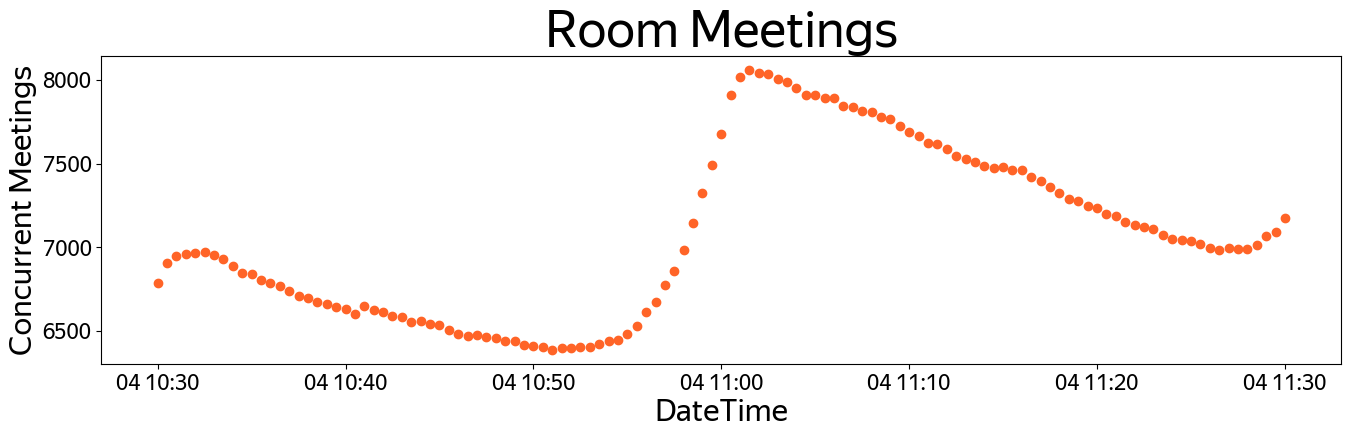

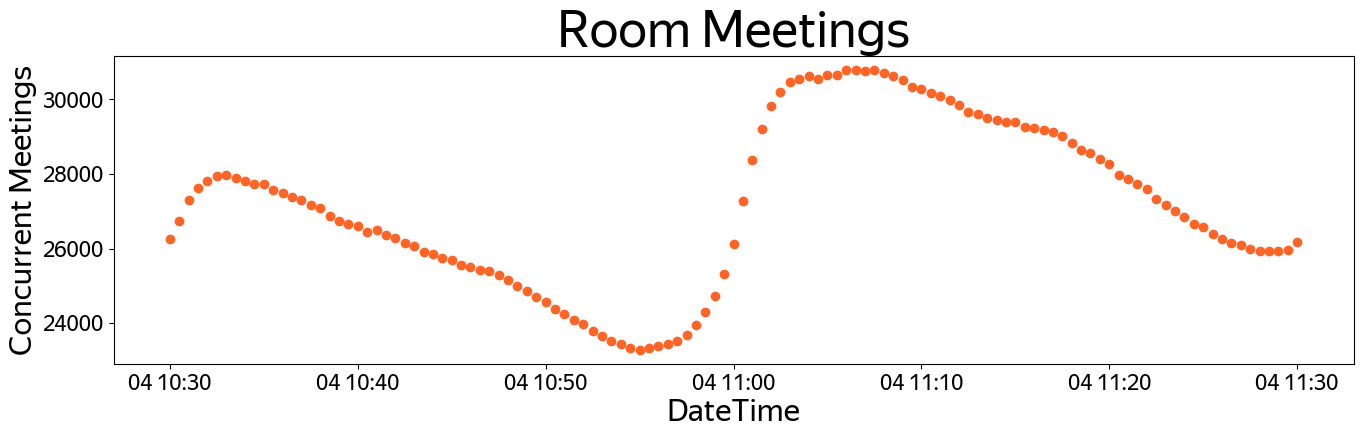

In [43]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
ax.set_title('Room Meetings', fontsize=36, fontname=fontName)
ax.set_xlabel('DateTime', fontsize=22, fontname=fontName)
ax.set_ylabel('Concurrent Meetings', fontsize=22, fontname=fontName)
plt.scatter(x=date_range, y=roomMeetingsValues, color=fontColor, label='Room Meetings')

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
ax.set_title('Room Meetings', fontsize=36, fontname=fontName)
ax.set_xlabel('DateTime', fontsize=22, fontname=fontName)
ax.set_ylabel('Concurrent Meetings', fontsize=22, fontname=fontName)
plt.scatter(x=date_range, y=concurrentPeerConnectionsValues, color=fontColor, label='Room Meetings')

In [4]:
def plotComparison(ping, caption, rps):
    cps_no_locks = pd.read_csv(f'cps_false+ping_{ping}_rps_{rps}.csv', header=0, names=['time', 'rps'])
    cps_with_locks = pd.read_csv(f'cps_true+ping_{ping}_rps_{rps}.csv', header=0, names=['time', 'rps'])

    conn_no_locks = pd.read_csv(f'connections_false+ping_{ping}_rps_{rps}.csv', header=0, names=['time', 'conn'])
    conn_with_locks = pd.read_csv(f'connections_true+ping_{ping}_rps_{rps}.csv', header=0, names=['time', 'conn'])

    mean_val_cps_no_locks = mean(cps_no_locks['rps'])
    mean_val_cps_with_locks = mean(cps_with_locks['rps'])
    
    mean_val_conn_no_locks = mean(conn_no_locks['conn'])
    mean_val_conn_with_locks = mean(conn_with_locks['conn'])
    
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.set_title(caption, fontsize=36, fontname=fontName)
    ax.set_xlabel('Time, millis', fontsize=22, fontname=fontName)
    ax.set_ylabel('RPS', fontsize=22, fontname=fontName)
    plt.scatter(x=cps_no_locks['time'], y=cps_no_locks['rps'], color=fontColor, label='No Locks. Mean: ' + f'{mean_val_cps_no_locks:.3f}')
    plt.axhline(y = mean_val_cps_no_locks, color = fontColor, linestyle = '-', linewidth=4)
    
    plt.scatter(x=cps_with_locks['time'], y=cps_with_locks['rps'], color=fontColor2, label='With Locks. Mean: ' + f'{mean_val_cps_with_locks:.3f}')
    plt.axhline(y = mean_val_cps_with_locks, color = fontColor2, linestyle = '-', linewidth=4)
    
    ax.grid()
    plt.legend(fontsize=22, loc ="upper right")
    plt.show()

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.set_title(caption, fontsize=36, fontname=fontName)
    ax.set_xlabel('Time, millis', fontsize=22, fontname=fontName)
    ax.set_ylabel('PG Connections', fontsize=22, fontname=fontName)
    plt.scatter(x=conn_no_locks['time'], y=conn_no_locks['conn'], color=fontColor, label='No Locks. Mean: ' + f'{mean_val_conn_no_locks:.3f}')
    plt.axhline(y = mean_val_conn_no_locks, color = fontColor, linestyle = '-', linewidth=4)
    
    plt.scatter(x=conn_with_locks['time'], y=conn_with_locks['conn'], color=fontColor2, label='With Locks. Mean: ' + f'{mean_val_conn_with_locks:.3f}')
    plt.axhline(y = mean_val_conn_with_locks, color = fontColor2, linestyle = '-', linewidth=4)
    
    ax.grid()
    plt.legend(fontsize=22, loc ="upper right")
    plt.show()

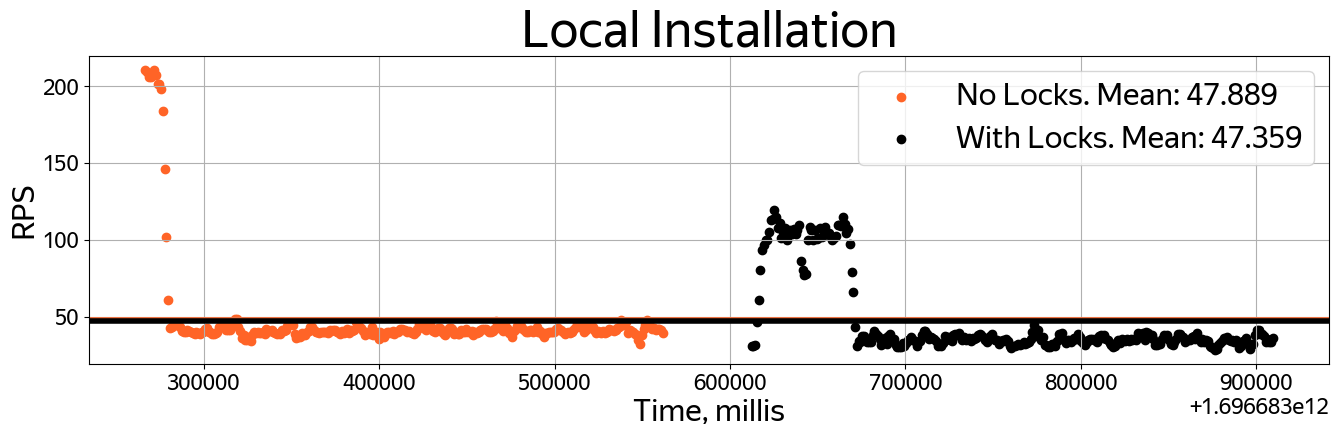

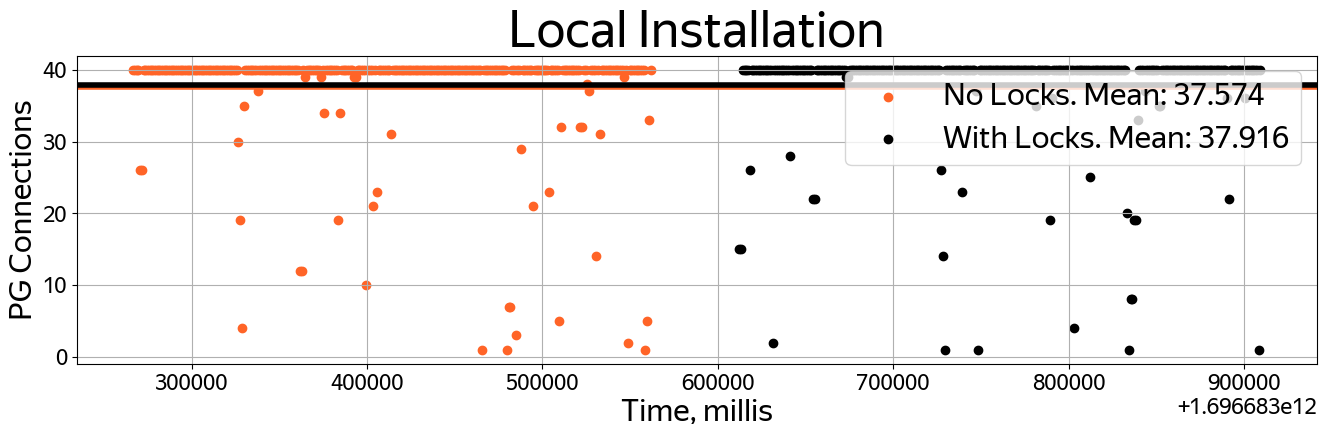

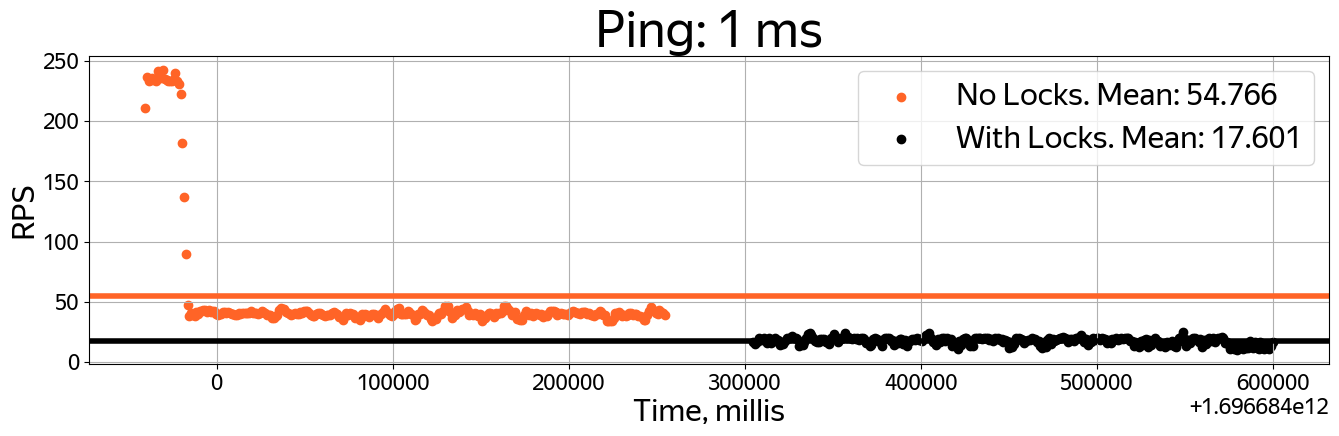

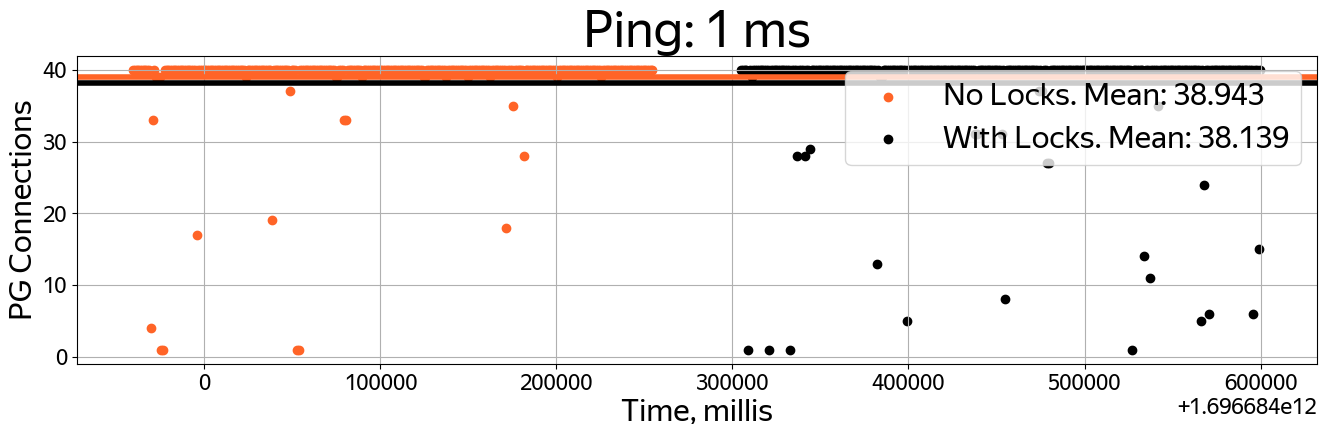

FileNotFoundError: [Errno 2] No such file or directory: 'cps_false+ping_1_rps_10.csv'

In [5]:
plotComparison('0', 'Local Installation', 0)
plotComparison('1', 'Ping: 1 ms', 0)
plotComparison('1', 'Ping: 1 ms, throttled', 10)
plotComparison('30', 'Ping: 30 ms', 0)

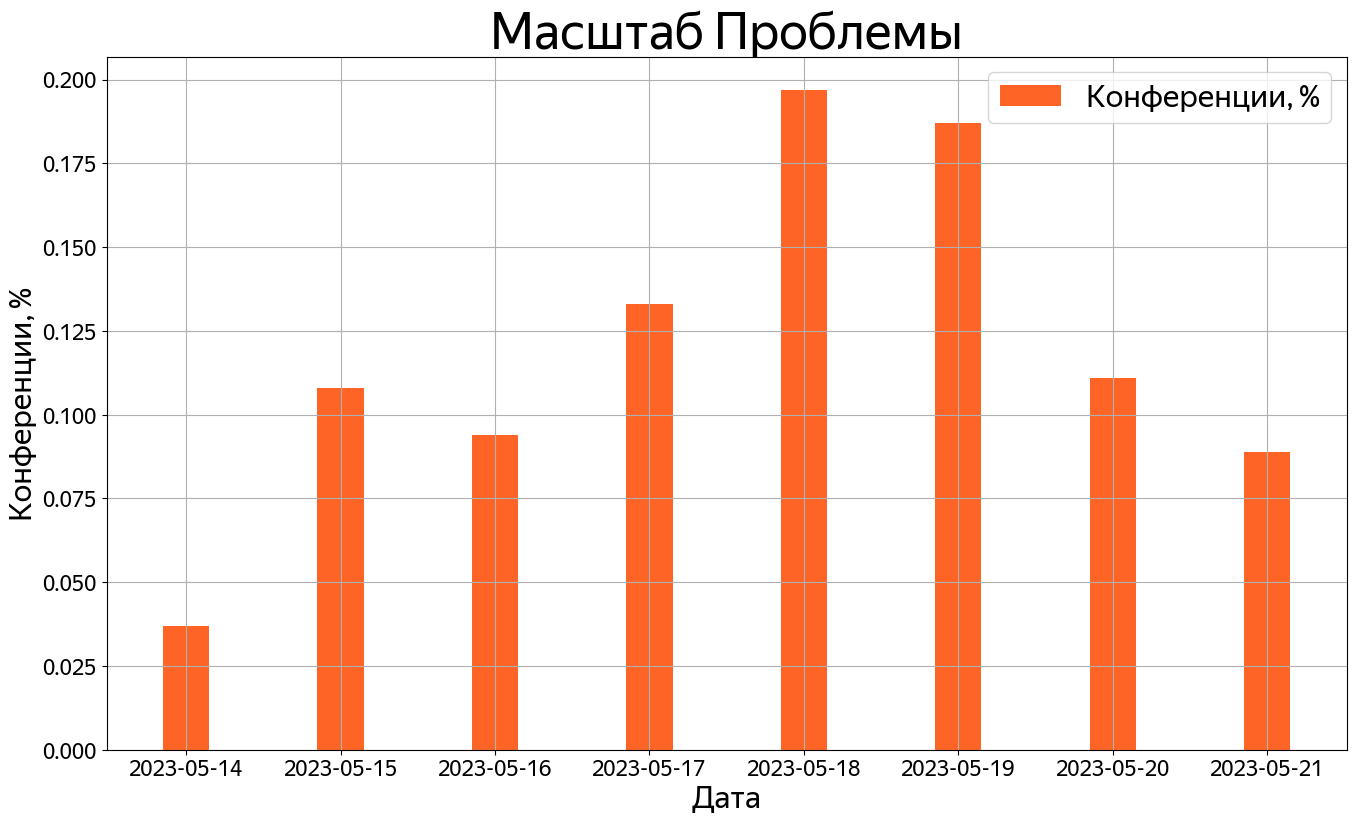

In [3]:
problem_scale = pd.read_csv('prepared/problem_scale.csv', header=0, names=['date', 'num_confs'])
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('Масштаб Проблемы', fontsize=36, fontname=fontName)
ax.set_xlabel('Дата', fontsize=22, fontname=fontName)
ax.set_ylabel('Конференции, %', fontsize=22, fontname=fontName)
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 1])
# plt.scatter(x=problem_scale['date'], y=problem_scale['num_confs'], s=200, marker='s', color='brown', label='Количество конференций')
plt.bar(problem_scale['date'], problem_scale['num_confs'], label='Конференции, %', color=fontColor, width= 0.3)
ax.grid()
plt.legend(fontsize=22, loc ="upper right")
plt.show()

In [1]:
data_no_locks = pd.read_csv('prepared/real_setup_no_locks.csv', header=0, names=['time', 'rps'])
data_with_locks = pd.read_csv('prepared/real_setup_with_locks.csv', header=0, names=['time', 'rps'])

mean_val_no_locks = mean(data_no_locks['rps'])
mean_val_with_locks = mean(data_with_locks['rps'])

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('В полной сборке', fontsize=36, fontname=fontName)
ax.set_xlabel('Time, sec', fontsize=22, fontname=fontName)
ax.set_ylabel('RPS', fontsize=22, fontname=fontName)
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 1])
plt.scatter(x=data_no_locks['time'], y=data_no_locks['rps'], color=fontColor, label='Mean: ' + f'{mean_val_no_locks:.3f}')
plt.axhline(y = mean_val_no_locks, color = fontColor, linestyle = '-', linewidth=4)

plt.scatter(x=data_with_locks['time'], y=data_with_locks['rps'], color=fontColor2, label='Mean: ' + f'{mean_val_with_locks:.3f}')
plt.axhline(y = mean_val_with_locks, color = fontColor2, linestyle = '-', linewidth=4)

ax.grid()
plt.legend(fontsize=22, loc ="upper right")
plt.show()

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('В полной сборке. С локами', fontsize=36, fontname=fontName)
ax.set_xlabel('Time, sec', fontsize=22, fontname=fontName)
ax.set_ylabel('RPS', fontsize=22, fontname=fontName)
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_xlim([0, 1])
# ax.set_ylim([0, 1])

plt.scatter(x=data_with_locks['time'], y=data_with_locks['rps'], color=fontColor2, label='Mean: ' + f'{mean_val_with_locks:.3f}')
plt.axhline(y = mean_val_with_locks, color = fontColor2, linestyle = '-', linewidth=4)

ax.grid()
plt.legend(fontsize=22, loc ="upper right")
plt.show()

NameError: name 'pd' is not defined

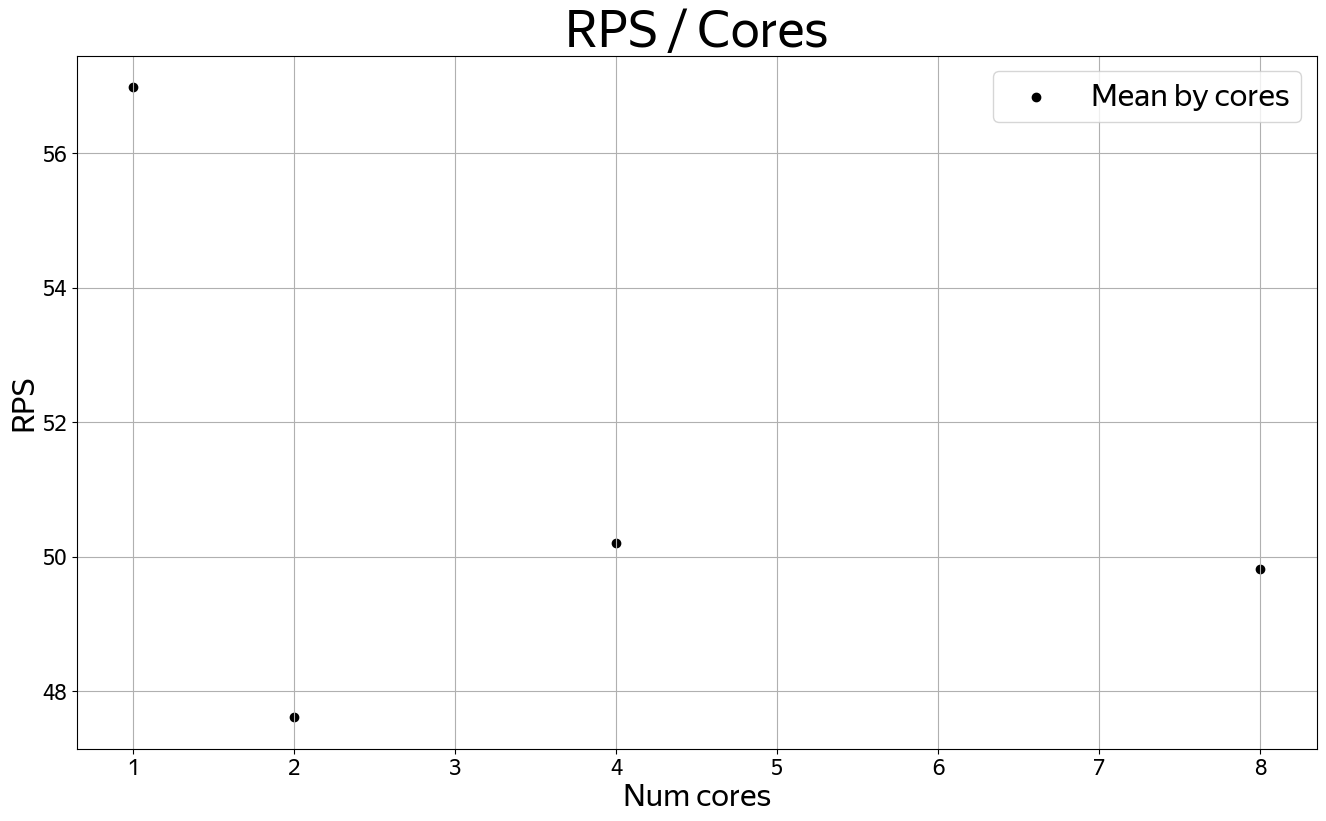

In [4]:
by_cores = [1,2,4,8]
data_rps_core = []
mean_by_cores = []

for i, cores in enumerate(by_cores):
    data_by_core = pd.read_csv(f'prepared/cores/{cores}/cps_false+ping_0_rps_0.csv', header=0, names=['time', 'rps'])
    mean_by_core = mean(data_by_core['rps'])
    
    data_rps_core.append(data_by_core)
    mean_by_cores.append(mean_by_core)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('RPS / Cores', fontsize=36, fontname=fontName)
ax.set_xlabel('Num cores', fontsize=22, fontname=fontName)
ax.set_ylabel('RPS', fontsize=22, fontname=fontName)

plt.scatter(x=by_cores, y=mean_by_cores, color=fontColor2, label='Mean by cores')

ax.grid()
plt.legend(fontsize=22, loc ="upper right")
plt.show()